# FEM Beispiel: Schwingende Membran (Poisson dynamisch)

#####  Zur Verfügung gestellt vom Institut für Mechanik der Montanuniversität Leoben 
#####  Kontakt für Fragen und Anmerkungen: wolfgang.flachberger@stud.unileoben.ac.at

## Einführung

Im Beispiel "Poisson Gleichung" wurde bereits erwähnt, dass die Poisson Gleichung verwendet werden kann um die Absenkung einer Membran unter bestimmten Belastungen zu ermitteln. 

$$ \Delta u(\underline{x}) + q(\underline{x}) = 0 $$ 

Hierbei wäre $q(x,y)[N/m^2]$ die beliebig verteilte "Flächenlast". Natürlich kann eine Membran auch schwingen. Ohne Gravitationskraft kann das Problem der schwingenden Membran wie folgt formuliert werden:

$$ \Delta u(\underline{x}) - \rho \ddot{u}(\underline{x}) = 0  $$ 
 
Eine Finite Elemente Analyse überführt diese lineare und zeitabhängige partielle Differentialgleichung auf ein lineares system gewöhnlicher Differentialgleichungen:

$$ \underline{\underline{M}} \; \ddot{\underline{U}} + \underline{\underline{K}} \; \underline{U} = 0 $$

Wobei die Gesamtsteifigkeitsmatrix $K$ gleich bestimmt werden kann wie im Beispiel "Poisson Gleichung" und die Massenmatrix $M$ als diagonale Einheitsmatrix angenommen werden soll. Deshalb sind die folgenden Abschnitte bis zum aufstellen der Gesamtsteifigkeitsmatrix die selben wie im Beispiel "Poisson Gleichung".

## Element-Typ und Ansatzfunktionen

Um Elementsteifigkeitsmatrix und Elementlastvektor explizit angeben zu können muss zuerst ein geeigneter Element-Typ mit passenden Ansatzfunktionen gewählt werden. Für zweidimensionale Problemstellungen hat man die Wahl zwischen dreiecks- und vierecks-Elementen verschiedener Ordnung. Wir entscheiden uns für viereckige Elemente mit linearen Ansatzfunktionen und daher vier Knoten (diese können als das zweidimensionale Pendant zu linearen stabelementen verstanden werden). Da die Ansatzfunktionen beim Ritz'sche Verfahren für die Poisson Gleichung nur einmal differenziert werden müssen genügt dieser einfache Element-Typ. Wir benötigen also die folgenden vier Ansatzfunktionen (eine für jeden Knoten):

In [1]:
import numpy
import sympy

l = 2 # länge des elements 

XI = numpy.asarray(sympy.symbols('xi:' + str(2))) # symbolischer vector mit lokalen koordinaten

def interpolationFunctions(XI, l): 

        h = sympy.ones(4,1) # initialisiere symbolischen spaltenvektor für ansatzfunktionen
         
        # ansatzfunktionen: eine für jeden knoten
        h[0] = ( 1 - XI[0] * 2/l )*( 1 - XI[1] * 2/l )/4
        h[1] = ( 1 - XI[0] * 2/l )*( 1 + XI[1] * 2/l )/4
        h[2] = ( 1 + XI[0] * 2/l )*( 1 - XI[1] * 2/l )/4
        h[3] = ( 1 + XI[0] * 2/l )*( 1 + XI[1] * 2/l )/4

        return h
    
h = interpolationFunctions(XI, l)  


from IPython.display import display
#sympy.init_printing()
print("lokale Koordinaten:")
print("-------------------")    
for i in range(len(XI)):
    display(XI[i])
print("Ansatzfunktionen:")
print("-----------------")    
display(h)

lokale Koordinaten:
-------------------


xi0

xi1

Ansatzfunktionen:
-----------------


Matrix([
[(1 - xi0)*(1 - xi1)/4],
[(1 - xi0)*(xi1 + 1)/4],
[(1 - xi1)*(xi0 + 1)/4],
[(xi0 + 1)*(xi1 + 1)/4]])

Natürlich hat jede Ansatzfunktion den Wert "1" im zugehörigen Knoten und den Wert "0" in jedem anderen Knoten. Zum besseren Verständnis visualisieren wir exemplarisch eine der Ansatzfunktionen:

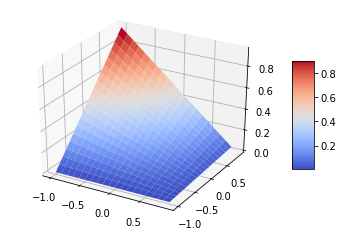

In [2]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

X = numpy.arange(-1, 1, 0.1)
Y = numpy.arange(-1, 1, 0.1)
X, Y = numpy.meshgrid(X, Y)
Z = ( 1 - X )*( 1 + Y )/4

# Visualization
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Zum Aufstellen der Elementsteifigkeitsmatrix benötigen wir ebenfalls die Ableitungen der Ansatzfunktionen:

In [3]:
def interpolationFunctionsDerivatives(XI, h):
        """ interpolationfunction[node, derivativeaxis] """
        dh_dX = sympy.ones(4, 2) 
        for index in range(4): 
            for axis in range(2):
                dh_dX[index,axis] = sympy.diff(h[index], XI[axis]) 
        return dh_dX 
    
dh_dx = interpolationFunctionsDerivatives(XI, h)

print("Ableitungen der Ansatzfunktionen:")
print("---------------------------------------")    
display(dh_dx)

Ableitungen der Ansatzfunktionen:
---------------------------------------


Matrix([
[ xi1/4 - 1/4,  xi0/4 - 1/4],
[-xi1/4 - 1/4,  1/4 - xi0/4],
[ 1/4 - xi1/4, -xi0/4 - 1/4],
[ xi1/4 + 1/4,  xi0/4 + 1/4]])

Da wir ein zweidimensionales Problem behandeln müssen die Ansatzfunktionen natürlich jeweils in $\xi_0$- und $\xi_1$-Richtung (praktisch in x und y) abgeleitet werden. Die resultierenden Funktionen sehen so aus:

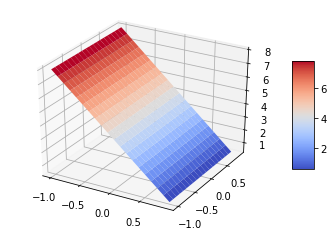

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = numpy.arange(-1, 1, 0.1)
Y = numpy.arange(-1, 1, 0.1)
X, Y = numpy.meshgrid(X, Y)
Z = (-X + 1) * 4

# Visualization
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Definieren des Variationsproblems

Im folgenden "input skript" werden Problemstellung und Lösungsparameter genau definiert:

In [5]:
""" input skript """ 


""" Definiere mesh """ 
# Bereich = alle (x,y)-wertepaare für die gilt: 0<x<1 und 0<y<1 
domain = [(0,1), (0,1)] 

# seitenlänge der finiten elemente ("auflösung")
resolution = 0.05 #0.1 #0.02


""" Definiere Rand """ 
def boundary(X_b): 
    xb0 = X_b[0]
    xb1 = X_b[1]
    
    b11 = xb0
    b12 = 0.0
    
    b21 = xb0 - 1.0
    b22 = 0.0
    
    b31 = 0.0
    b32 = xb1
    
    b41 = 0.0
    b42 = xb1 - 1.0
    
    return [[b11, b12],[b21, b22],[b31, b32],[b41, b42]]


""" Definiere Randwerte """ 
def boundaryValue(X_b): 
    xb0 = X_b[0]
    xb1 = X_b[1]
    return 0

Jetzt muss noch die Operatorgleichung definiert werden:

In [6]:
X = numpy.asarray(sympy.symbols('x:' + str(2)))
dv_dx = numpy.asarray(sympy.symbols('v_x:' + str(2)))
du_dx = numpy.asarray(sympy.symbols('u_x:' + str(2)))

# Operatorgleichung
Au = numpy.dot( du_dx, dv_dx ) 

# Ausgabe
print("Operatorgleichung (Au) :")
print("------------------------")
display(Au)

Operatorgleichung (Au) :
------------------------


u_x0*v_x0 + u_x1*v_x1

### ESM 

Die Überführung des Variationsproblems in ein lineares Gleichungssystem beginnt mit der Berechnung der Komponenten der Elementsteifigkeitsmatrix. Im Allgemeinen muss diese für jedes Element einzeln berechnet werden. Das ist auch die übliche Vorgehensweise gebräuchlicher FE-Softwaretools. Im Falle der Poisson Gleichung kann man sich aber die Tatsache zu nutze machen, dass keine Koordinaten (x,y) explizit in der Operatorgleichung auftauchen und die ESM deshalb für jedes Finite Element gleich aussehen muss. Im folgenden wird eine Funktion aufgerufen welche durch analytische Integration das folgende Problem löst:

$$ k_{ij}^{(e)} = \int_{\frac{-l_{e}}{2}}^{\frac{l_{e}}{2}} \int_{\frac{-l_{e}}{2}}^{\frac{l_{e}}{2}} \frac{\partial h_i}{\partial \xi_0} \frac{\partial h_j}{\partial \xi_0} + \frac{\partial h_i}{\partial \xi_1} \frac{\partial h_j}{\partial \xi_1} d \xi_0 d \xi_1 $$

Hierbei steht $l_{e}$ für die Seitenlänge eines finiten Elements.

In [7]:
# ansatzfunktionen und deren ableitungen
h = interpolationFunctions(XI, resolution)  
dh_dx = interpolationFunctionsDerivatives(XI, h)


def elementStiffnessMatrixAnalytic(Au, dv_dx, du_dx, h, dh_dx, X, XI, resolution): 
    
    k_ij = sympy.zeros(4,4)
    for i in range(4): 
        for j in range(4):
            k_ij[i,j] = Au.subs([(du_dx[0], dh_dx[i,0]), (du_dx[1], dh_dx[i,1]), (dv_dx[0], dh_dx[j,0]), (dv_dx[1], dh_dx[j,1])])   
    
    # prepare substitution for coordinate transformation
    x_to_xi = []
    for j in range(2):
        x_to_xi.append( (X[j], XI[j] + X[j]) )
    
    # transform to local coordinate frame and integrate
    for indices in numpy.ndindex(k_ij.shape):  
        k_ij[indices] = k_ij[indices].subs(x_to_xi)    
        for i in range(2): 
            k_ij[indices] = sympy.integrate(k_ij[indices],(XI[i],-resolution/2,resolution/2))
    
    return k_ij

k_ij = elementStiffnessMatrixAnalytic(Au, dv_dx, du_dx, h, dh_dx, X, XI, resolution)
print("Elementsteifigkeitsmatrix:")
print("--------------------------")
display(k_ij.evalf(3))   

Elementsteifigkeitsmatrix:
--------------------------


Matrix([
[ 0.667, -0.167, -0.167, -0.333],
[-0.167,  0.667, -0.333, -0.167],
[-0.167, -0.333,  0.667, -0.167],
[-0.333, -0.167, -0.167,  0.667]])

### FE-Mesh

Im Folgenden wird berechnet wie viele Elemente und globale Freiheitsgrade benötigt werden um den mit "domain" definierten Bereich mit Elementen der seitenlänge "resolution" zu füllen:

In [8]:
import numpy 

dimension = 2
nodes_per_element = 4
nr_el_dim = [] # initialize list with number of elements necessary per axis
nr_nd_dim = [] # initialize list with number of nodes necessary per axis
for index in range(dimension): # for every dimension
    length = domain[index][1] - domain[index][0] # take length of "box"
    nr_el_dim.append(int(length/resolution)) # approximate the domain (division without remainder)
    nr_nd_dim.append(nr_el_dim[index] + 1)
    pass
nr_el_dim = tuple(nr_el_dim)
nr_nd_dim = tuple(nr_nd_dim)
number_elements = numpy.prod(nr_el_dim) # total amount of elements
DoF = numpy.prod(nr_nd_dim) # total amount of gloabal nodes (= DoFs)

print("Anzahl Elemente = ",number_elements)
print("Freiheitsgrade (Knoten) =", DoF)

Anzahl Elemente =  400
Freiheitsgrade (Knoten) = 441


Als nächstes erhält jeder globale Freiheitsgrad einen Namen (Nummer) und wird in einem array gespeichert in welchem er den selben index besitzt wie im mesh:

In [9]:
# initialize a list-array: 0, 1, 2,..
nodes = numpy.arange(DoF,dtype=int)

# da es nicht wichtig ist wie die knoten nummeriert werden kann "reshape" verwendet werden
node_names_global = numpy.reshape(nodes,(nr_nd_dim),order='C')

print("FE-Mesh:")
print("--------")
print(node_names_global)

FE-Mesh:
--------
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20]
 [ 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
   39  40  41]
 [ 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
   60  61  62]
 [ 63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
   81  82  83]
 [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
  102 103 104]
 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
  123 124 125]
 [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167]
 [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
  186 187 188]
 [189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
  207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
  228 229 230]
 [2

Man kann sich das obige Array bereits als sehr simple Repräsentation eines FE-meshes vorstellen bei dem jede Zahl für einen Knoten, also einen globalen Freiheitsgrad, steht. 

### Die Koinzidenztabelle

In der Koinzidenztabelle wird festgehalten wie die Finiten Elemente verknüpft sind, also welche lokalen Knoten sich überlagern. 

In [10]:
def coincidenceTable(number_elements, nodes_per_element, dimension, nr_el_dim, node_names_global): 
        """ coincidence_table[element,node] """
        
        # initialize coincidence table array 
        coincidence_table = numpy.zeros((number_elements,nodes_per_element), dtype=int, order='C')
        
        i = 0 # set row count to zero
        for element_indices in numpy.ndindex(nr_el_dim): # for every element
            j = 0 # set local node count to zero
            for node_indices in numpy.ndindex((2,)*dimension): # for every local node in elmenet
                location = tuple([sum(x) for x in zip(element_indices,node_indices)])# find global location of node
                coincidence_table[i,j] = node_names_global[location] # put node name to table
                j += 1 # next element in row
                pass
            i += 1 # next row
            pass
        return coincidence_table    

T = coincidenceTable(number_elements, nodes_per_element, dimension, nr_el_dim, node_names_global)

print("Koinzidenztabelle:")
print("------------------")
print(T)   

Koinzidenztabelle:
------------------
[[  0   1  21  22]
 [  1   2  22  23]
 [  2   3  23  24]
 ...
 [416 417 437 438]
 [417 418 438 439]
 [418 419 439 440]]


Die vier spalten der Koinzidenztabelle stehen für die vier lokalen Freiheitsgrade des Elementtyps während die Zeilen für individuelle Elemente im mesh stehen. Die Einträge sind die Namen der globalen Freiheitsgrade. Vergleicht man Koinzidenztabelle und mesh so kann man leicht überprüfen ob die Koinzidenztabelle korrekt aufgestellt wurde.

### Assembly

Im Assembly werden aus ESM und ELV die Gesamtsteifigkeitsmatrix sowie der Lastvektor aufgebaut. Unter Verwendung der Koinzidenztabelle werden die ESMs bzw. ELVs so überlagert, dass das resultierende Geichungssystem einen Wert für jeden Freiheitsgrad (Knoten) liefert. Bei Anwendung des Ritz'schen Verfahrens erhält man eine symmetrische Gesamtsteifigkeitsmatrix:

In [11]:
def assemble(T, DoF, k_ij, X, nodes_per_element, resolution): 
        
    # initialize transport arrays    
    k = numpy.zeros((nodes_per_element, nodes_per_element))    
    
    # initialize stiffnessmatrix of the whole system
    K_ = numpy.zeros((DoF,DoF)) 
   
    el = 0 # element counter
    for e_index in numpy.ndindex(nr_el_dim): # for every element
        
        # prepare substitution for element
        evaluate = []
        e_location = numpy.asarray(e_index) * resolution + numpy.ones(dimension)*resolution
        for i in range(dimension):
            evaluate.append( (X[i], e_location[i] ))
            
        # evaluate k_ij and f_j for element  
        for indices in numpy.ndindex((nodes_per_element, nodes_per_element)):  
            k[indices] = k_ij[indices].subs(evaluate)  
            
            
        # assemble K_ and F_ 
        for k_index in numpy.ndindex((nodes_per_element, nodes_per_element)): 
            i = T[el,k_index[0]]
            j = T[el,k_index[1]]
            K_[i,j] += k[k_index] #round(k[k_index],1)

      
        el += 1 # next element
    
    return K_

K_ = assemble(T, DoF, k_ij, X, nodes_per_element, resolution)

numpy.set_printoptions(precision=3)
print("Gesamtsteifigkeitmatrix :")
print("-------------------------") 
print(K_)


Gesamtsteifigkeitmatrix :
-------------------------
[[ 0.667 -0.167  0.    ...  0.     0.     0.   ]
 [-0.167  1.333 -0.167 ...  0.     0.     0.   ]
 [ 0.    -0.167  1.333 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  1.333 -0.167  0.   ]
 [ 0.     0.     0.    ... -0.167  1.333 -0.167]
 [ 0.     0.     0.    ...  0.    -0.167  0.667]]


### Randbedingungen

Nachdem definiert wurde wo genau der Rand des Bereichs liegt an dem Werte vorgegeben werden müssen, werden jene Knoten gesucht welche auf diesem Rand liegen. Das nachfolgende Skript sucht diese Knoten und gibt ihre Namen aus:

In [12]:
def removeDuplicates(listofElements):
    # Create an empty list to store unique elements
    uniqueList = []
    # Iterate over the original list and for each element
    # add it to uniqueList, if its not already there.
    for elem in listofElements:
        if elem not in uniqueList:
            uniqueList.append(elem)
    # Return the list of unique elements        
    return uniqueList


def boundaryNodes(boundary, domain, nr_nd_dim, dimension, resolution): 
    node_locations_global = numpy.zeros(nr_nd_dim + (dimension,))
    initialPoint = []
    for i in range(dimension): 
        initialPoint.append(domain[i][0])
    initialPoint = numpy.asarray(initialPoint)
    for indices in numpy.ndindex(nr_nd_dim):
        step = numpy.asarray(list(indices))
        node_locations_global[indices] = initialPoint + step * resolution
    boundary_nodes = []
    boundary_node_indices = []
    for i in range(4):
        for indices in numpy.ndindex(nr_nd_dim):    
            if boundary(node_locations_global[indices])[i] == [0.0, 0.0]: 
                boundary_nodes.append(node_names_global[indices])
                boundary_node_indices.append(indices)
        if boundary_nodes == []: 
            print("ERROR: no boundary nodes found.")
    return removeDuplicates(boundary_nodes), removeDuplicates(boundary_node_indices), node_locations_global


bNodes, bNodeInd, nodeLoc = boundaryNodes(boundary, domain, nr_nd_dim, dimension, resolution)


print("Boundary Nodes :")
print("----------------") 
print(bNodes)

Boundary Nodes :
----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231, 252, 273, 294, 315, 336, 357, 378, 399, 41, 62, 83, 104, 125, 146, 167, 188, 209, 230, 251, 272, 293, 314, 335, 356, 377, 398, 419]


Als nächstes werden die Randwerte in den betreffenden Knoten, durch Vorgabe an der korrespondierenden Stelle im Lösungsvektor, eingebracht. Im Falle der Vorgabe des Randwertes "0" in einem Knoten, reicht es deshalb, betreffenden Zeilen und Spalten in GSM und LV zu "streichen" (siehe Skriptum). Bei der Vorgabe von Randwerten die ungleich Null sind muss anders vorgegangen werden. Das folgende Skript kann beliebige Randwerte einbringen und löst anschließend das verbleibende Gleichungssystem:

In [13]:
from numpy.linalg import inv, eig

def applyBoundaryCondition(modes, K_, boundaryValue, DoF, bNodes, bNodeInd, nodeLoc, nr_nd_dim): 
    
    U_ = numpy.zeros((DoF,1))
    i = 0
    for node in bNodes:
        U_[node] = boundaryValue(nodeLoc[bNodeInd[i]])
        i += 1


    # delete rows with fixed U values from the system of equations
    K_ = numpy.delete(K_, bNodes, 0)
    K_ = numpy.delete(K_, bNodes, 1)

    
    w, v = eig(K_)
    Modes = []

    for mode in range(modes):
        U_ = v[:,mode]
        
    
        # insert boundary values
        bvals =[] 
        for i in bNodeInd: 
            bvals.append(boundaryValue(nodeLoc[i]))
    
        sorted_bNodes = sorted(bNodes) 
        for i in range(len(bNodes)): 
            U_ = numpy.insert(U_, sorted_bNodes[i], 0.0)
        
        c = 0
        for i in bNodes: 
            U_[i] = bvals[c]
            c += 1
        
        U_ = numpy.array([U_]).T 
        
        u = numpy.reshape(U_,(nr_nd_dim),order='C')    
        Modes.append(u)
        
    return Modes, w

def membraneModes(Modes, w, t):
    modes = len(Modes) 
    m = numpy.zeros(Modes[0].shape)
    for i in range(modes): 
        m += Modes[i] * numpy.sin(w[i]*t)  
    return m   


def membraneMode(Modes, w, mode, t):
    return Modes[mode] * numpy.sin(w[mode]*t)

Es soll nun eine Modalanalyse der folgenden Gleichunssystems durchgefürt werden:

$$ \underline{\underline{M}} \; \ddot{\underline{U}} + \underline{\underline{K}} \; \underline{U} = \underline{0} $$

Hierbei wird $M$ als Einheitsmatrix definiert. Für $U$ wird der für Modalanalysen übliche Ansatz gemacht:
$$ \underline{U}(t) = \underline{\hat{U}} e^{i \omega t} $$ 

Das einsetzen in die Gleichung führt auf das Folgende Eigenwertproblem:

$$ (-\omega^2_k \underline{\underline{M}} + \underline{\underline{K}}) \; \underline{\hat{U}}_k = \underline{0}$$ 

$\underline{\hat{U}}_k$ sind die Eigenvektoren des systems und $\omega_k$ die zugehörigen Eigenwerte. Die Eigenvektoren können mittels Koinzidenztabelle als spezielle Konfiguration der Membran dargestellt werden welche mit der zugehörigen Kreisfrequenz, dem Eigenwert, sinusförmig auf und ab schwingt. Eine allgemeine Lösung kann deshalb dargestellt werden indem alle Lösungen (=Moden) superpositioniert werden und, abhängig vom Anfangswert, mit einer Amplitude $a_k$ skaliert werden.

$$ \underline{U}(t) = \sum_{k=1}^{DoF} a_k \underline{\hat{U}}_k \sin(\omega_k t) $$

### Visualisierung

Zum besseren Verständnis können hier die Schwingung einzelner Moden betrachtet werden.

$$ \underline{U}_k(t) = \underline{\hat{U}}_k \sin(\omega_k t) $$

RuntimeError: Requested MovieWriter (ffmpeg) not available

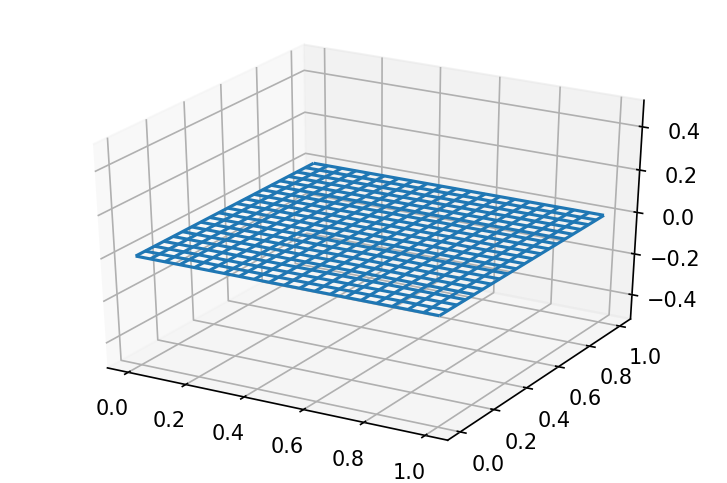

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib

""" gib hier den Index der Mode an die du sehen willst """

mode = 5 # k




modes = mode+1
Modes, w = applyBoundaryCondition(modes, K_, boundaryValue, DoF, bNodes, bNodeInd, nodeLoc, nr_nd_dim)

N = max(Modes[0].shape)-1 # Meshsize
fps = 24 # frame per sec
frn = 480 # frame number of the animation

x = np.linspace(0,1,N+1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N+1, N+1, frn))

for i in range(frn):
    zarray[:,:,i] = membraneMode(Modes, w, mode, i)
    
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plot = [ax.plot_wireframe(x, y, zarray[:,:,0])]
ax.set_zlim(-0.5,0.5)
    
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_wireframe(x, y, zarray[:,:,frame_number])
    
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)    

plt.rcParams['animation.html'] = 'html5'
ani

In Praxis können sich schwingungen aus verschiedenen Moden unterschiedlicher Amplituden zusammensetzen. Hier kann die überlagerung einiger Moden betrachtet werden. 

$$ \underline{U}(t) = \sum_{k=1}^{n} \underline{\hat{U}}_k \sin(\omega_k t) $$

RuntimeError: Requested MovieWriter (ffmpeg) not available

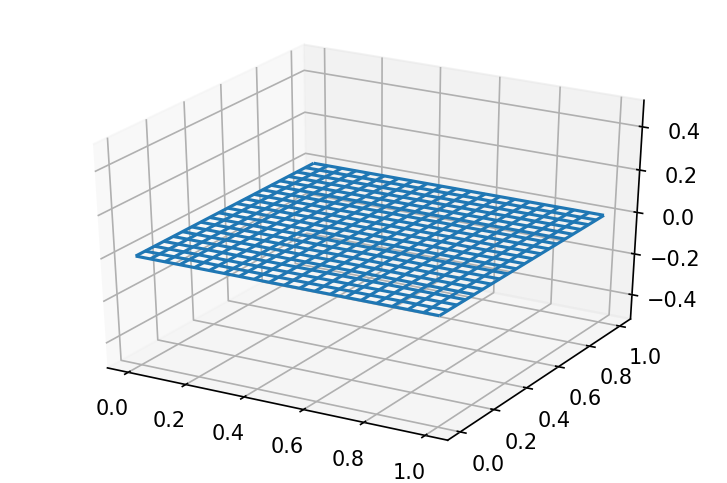

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib

""" gib hier die Anzahl Moden an die du überlagern willst """

modes = 6 # n





Modes, w = applyBoundaryCondition(modes, K_,  boundaryValue, DoF, bNodes, bNodeInd, nodeLoc, nr_nd_dim)

N = max(Modes[0].shape)-1 # Meshsize
fps = 24 # frame per sec
frn = 480 # frame number of the animation

x = np.linspace(0,1,N+1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N+1, N+1, frn))

for i in range(frn):
    zarray[:,:,i] = membraneModes(Modes, w, i)
    
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plot = [ax.plot_wireframe(x, y, zarray[:,:,0])]
ax.set_zlim(-0.5,0.5)
    
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_wireframe(x, y, zarray[:,:,frame_number])
    
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)    

plt.rcParams['animation.html'] = 'html5'
ani